# Vision Transformer Model - Fine-Tuning
## Plant Disease Image Classification - Corn Crop Leaves
MSDS 634 Deep Learning Final Project

# Table of Contents
**Experiments:**
1. [ViT Model - Version 1](#vit-v1)
1. [ViT Model - Version 2](#vit-v2)
1. [ViT Model - Version 3](#vit-v3)
**Final Model Results:**
1. [Final ViT Model Results](#vit-results)
   - [Load the data](#final-model-load-data)
   - [Load the model](#final-model-load-model)
   - [Evaluate the model on train](#final-model-train)
   - [Evaluate the model on val](#final-model-val)
   - [Print model classification report](#final-model-classification-report)
   - [Plot model confusion matrix](#final-model-cm)
   - [Display Misclassified Leaf Images](#final-model-misclassified-leaves)
   - [Visualize Saliency Map](#final-model-saliency-maps)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [ ]:
!pip install torchinfo

## Load Preprocessed Dataset

In [ ]:
# Load the numpy files - size 224x224 for ViT
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')
# test_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy')
# test_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Let's display a sample image as a sanity check to make sure we loaded the data properly:

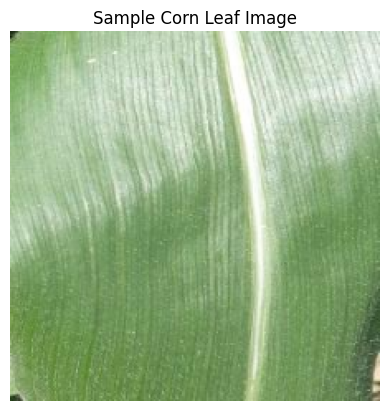

In [ ]:
sample_image = train_data[10]

# Display the sample image
plt.imshow(sample_image.transpose(1, 2, 0))  # Transpose the dimensions for displaying with matplotlib
plt.title('Sample Corn Leaf Image')
plt.axis('off')  # Turn off axis
plt.show()


## ViT Model - Version 1
* out of 12 encoder blocks, unfreeze the last 2 encoder blocks that are closer to the classification head
* run for 20 epochs with early stopping if validation f1 score lowers for 3 epochs
* batch_size = 256

In [ ]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


Now we can pass in these class weights into the loss function to account for the class imbalance. Then we can run our training loop as usual!

In [ ]:
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

**Unfreezing Strategy**
* Keep the bottom layers of the encoder frozen since they capture low-level features like edges and textures that are generally common across different types of images.
* Unfreeze the top layers of the encoder to allow the model to adapt and learn more high-level features specific to your task.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary

# Load the pre-trained ViT-B/16 model
model = models.vit_b_16(pretrained=True)

# Check if the model has a classifier head named 'head' and if it is an instance of nn.Linear
if hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
    # Replace the classifier head with a new one for the desired number of classes
    num_classes = 4  # Number of classes
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all parameters except the classification head
for name, param in model.named_parameters():
    if "head" not in name:  # Exclude parameters of the classification head
        param.requires_grad = False

# Unfreeze top layers of the encoder
num_encoder_layers = 12  # Assuming there are 12 encoder layers in total
# for i in range(8, num_encoder_layers):
for i in range(10, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Verify the freezing status of the parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Create a dummy input tensor and move it to the same device
dummy_input = torch.zeros(1, 3, 224, 224)

# Print out model summary
summary(model, input_data=dummy_input)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
# Took 1h 13m 44s
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))  # Only optimize unfrozen parameters

# Define early stopping parameters
patience = 3
best_val_f1 = 0.0
counter = 0

# Initialize dictionary to store epoch results
epoch_results = {
    'Epoch': [],
    'Train Loss': [],
    'Train F1 Score': [],
    'Val Loss': [],
    'Val F1 Score': []
}

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for data, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())
        progress_bar.set_postfix({'Loss': train_loss / len(progress_bar)})

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Add epoch results to the dictionary
    epoch_results['Epoch'].append(epoch + 1)
    epoch_results['Train Loss'].append(train_loss)
    epoch_results['Train F1 Score'].append(train_f1)
    epoch_results['Val Loss'].append(val_loss)
    epoch_results['Val F1 Score'].append(val_f1)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')

    # Check for improvement in validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        counter = 0
        # Save the best model
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)

# Load the best model
# model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/20, Train Loss: 0.6755, Train F1 Score: 0.7492, Val Loss: 0.2564, Val F1 Score: 0.8423


Epoch 2/20, Train Loss: 0.1590, Train F1 Score: 0.9295, Val Loss: 0.0941, Val F1 Score: 0.9668


Epoch 3/20, Train Loss: 0.0830, Train F1 Score: 0.9759, Val Loss: 0.0897, Val F1 Score: 0.9693


Epoch 4/20, Train Loss: 0.0467, Train F1 Score: 0.9881, Val Loss: 0.0803, Val F1 Score: 0.9740


Epoch 5/20, Train Loss: 0.0263, Train F1 Score: 0.9918, Val Loss: 0.1165, Val F1 Score: 0.9774


Epoch 6/20, Train Loss: 0.0116, Train F1 Score: 0.9963, Val Loss: 0.1073, Val F1 Score: 0.9676


Epoch 7/20, Train Loss: 0.0102, Train F1 Score: 0.9967, Val Loss: 0.1217, Val F1 Score: 0.9709


Epoch 8/20, Train Loss: 0.0071, Train F1 Score: 0.9967, Val Loss: 0.0990, Val F1 Score: 0.9689
Early stopping at epoch 8


In [ ]:
# Save the model architecture and weights
output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model
}, output_path_vit_v1_base + 'vit_v1_model.pth')

 # Save optimizer state - in case we want to resume training from where we left off, including continuing the optimization process with the same optimizer settings
torch.save(optimizer.state_dict(), output_path_vit_v1_base + 'vit_v1_optimizer.pth')


In [ ]:
# Save the model results to a csv
epoch_df.to_csv(output_path_vit_v1_base+'epoch_results.csv')

epoch_df

,Epoch,Train Loss,Train F1 Score,Val Loss,Val F1 Score
0,1,0.675521,0.749173,0.256384,0.842288
1,2,0.158968,0.929525,0.094125,0.966755
2,3,0.083050,0.975883,0.089735,0.969266
3,4,0.046718,0.988118,0.080304,0.974008
4,5,0.026301,0.991846,0.116483,0.977399
5,6,0.011619,0.996297,0.107251,0.967556
6,7,0.010172,0.996666,0.121700,0.970857
7,8,0.007090,0.996662,0.099014,0.968865


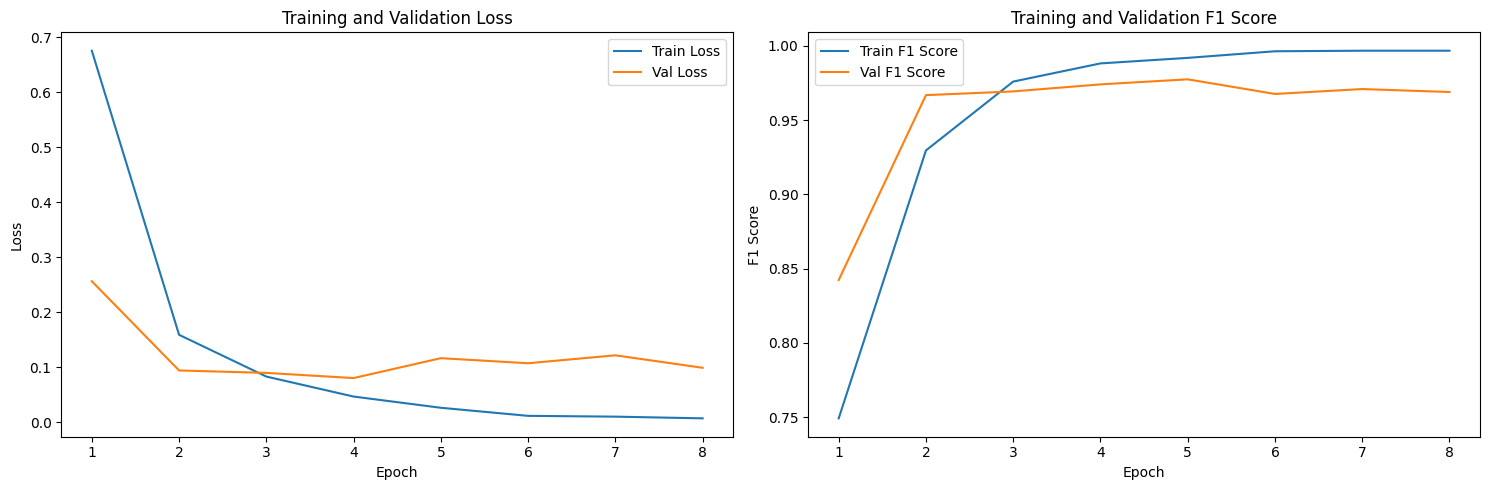

In [ ]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Test loading the model and evaluating it on validation set - took 1m 15s
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)  # Assuming you are loading the same architecture
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v1_base + 'vit_v1_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Save val_predictions and val_targets to a .npy file
np.save(output_path_vit_v1_base + 'vit_v1_val_predictions.npy', np.array(val_predictions))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Loss: 0.0990, Validation F1 Score: 0.9689


## ViT Model - Version 2
* out of 12 encoder blocks, unfreeze the last 1 encoder block that is closer to the classification head
* run for 20 epochs with early stopping if validation f1 score lowers for 2 epochs
* batch_size = 64
* added regularization
  * L2 regularization: weight_decay=1e-4
  * Dropout=0.2 (only applies to unfrozen parameters)

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [ ]:
!pip install torchinfo

### Load Preprocessed Dataset

In [ ]:
# Load the numpy files - size 224x224 for ViT
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')
# test_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy')
# test_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


Now we can pass in these class weights into the loss function to account for the class imbalance. Then we can run our training loop as usual!

In [ ]:
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

**Unfreezing Strategy**
* Keep the bottom layers of the encoder frozen since they capture low-level features like edges and textures that are generally common across different types of images.
* Unfreeze the top layers of the encoder to allow the model to adapt and learn more high-level features specific to your task.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary

# Load the pre-trained ViT-B/16 model
model = models.vit_b_16(pretrained=True)

# Check if the model has a classifier head named 'head' and if it is an instance of nn.Linear
if hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
    # Replace the classifier head with a new one for the desired number of classes
    num_classes = 4  # Number of classes
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all parameters except the classification head
for name, param in model.named_parameters():
    if "head" not in name:  # Exclude parameters of the classification head
        param.requires_grad = False

# Unfreeze top layers of the encoder
num_encoder_layers = 12  # Assuming there are 12 encoder layers in total
for i in range(11, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Add weight decay regularization to the optimizer
weight_decay = 1e-4  # Adjust the weight decay factor as needed
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), # only optimize the trainabile parameters
    weight_decay=weight_decay # L2 regularization
)

# Define the dropout rate
dropout_rate = 0.2  # Adjust as needed

# Add dropout layers to the unfrozen layers for regularization
for i in range(11, num_encoder_layers):
    # Insert dropout after the activation function in each layer
    model.encoder.layers[i].dropout = nn.Dropout(dropout_rate)

# Verify the freezing status of the parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Create a dummy input tensor and move it to the same device
dummy_input = torch.zeros(1, 3, 224, 224)

# Print out model summary
summary(model, input_data=dummy_input)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Took 1hr +
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm

output_path_vit_v2_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v2_best/'

# Define early stopping parameters
patience = 2
best_val_f1 = 0.0
counter = 0

# Initialize dictionary to store epoch results
epoch_results = {
    'Epoch': [],
    'Train Loss': [],
    'Train F1 Score': [],
    'Val Loss': [],
    'Val F1 Score': []
}

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for data, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())
        progress_bar.set_postfix({'Loss': train_loss / len(progress_bar)})

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Add epoch results to the dictionary
    epoch_results['Epoch'].append(epoch + 1)
    epoch_results['Train Loss'].append(train_loss)
    epoch_results['Train F1 Score'].append(train_f1)
    epoch_results['Val Loss'].append(val_loss)
    epoch_results['Val F1 Score'].append(val_f1)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')

    # Check for improvement in validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        counter = 0
        # Save the best model
        # torch.save(model.state_dict(), 'best_model.pth')
        print('Saving best model so far...')
        # Save the best model architecture and weights
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': model
        }, output_path_vit_v2_base + 'vit_v2_model.pth')

        # Save the best optimizer state - in case we want to resume training from where we left off, including continuing the optimization process with the same optimizer settings
        torch.save(optimizer.state_dict(), output_path_vit_v2_base + 'vit_v2_optimizer.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)

# Load the best model
# model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/20, Train Loss: 0.2978, Train F1 Score: 0.8841, Val Loss: 0.1454, Val F1 Score: 0.9403
Saving best model so far...


Epoch 2/20, Train Loss: 0.0884, Train F1 Score: 0.9711, Val Loss: 0.1047, Val F1 Score: 0.9702
Saving best model so far...


Epoch 3/20, Train Loss: 0.0468, Train F1 Score: 0.9851, Val Loss: 0.0681, Val F1 Score: 0.9723
Saving best model so far...


Epoch 4/20, Train Loss: 0.0240, Train F1 Score: 0.9930, Val Loss: 0.0893, Val F1 Score: 0.9724
Saving best model so far...


Epoch 5/20, Train Loss: 0.0104, Train F1 Score: 0.9967, Val Loss: 0.0999, Val F1 Score: 0.9759
Saving best model so far...


Epoch 6/20, Train Loss: 0.0065, Train F1 Score: 0.9978, Val Loss: 0.1129, Val F1 Score: 0.9725


Epoch 7/20, Train Loss: 0.0326, Train F1 Score: 0.9885, Val Loss: 0.2771, Val F1 Score: 0.9277
Early stopping at epoch 7


In [ ]:
# Save the model results to a csv
epoch_df.to_csv(output_path_vit_v2_base+'epoch_results.csv')

epoch_df

,Epoch,Train Loss,Train F1 Score,Val Loss,Val F1 Score
0,1,0.297815,0.884056,0.145354,0.940315
1,2,0.088438,0.971115,0.104732,0.970230
2,3,0.046800,0.985142,0.068117,0.972318
3,4,0.023987,0.992960,0.089301,0.972379
4,5,0.010365,0.996661,0.099851,0.975882
5,6,0.006498,0.997776,0.112888,0.972550
6,7,0.032595,0.988516,0.277141,0.927712


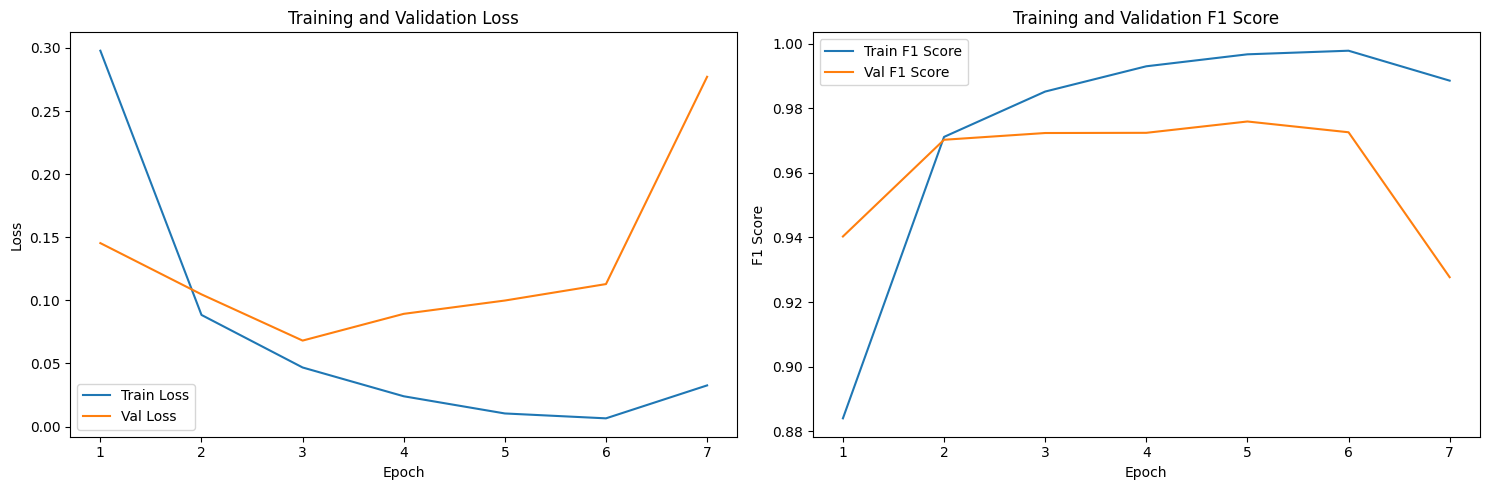

In [ ]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Test loading the model and evaluating it on validation set - took ??
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)  # Assuming you are loading the same architecture
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v2_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v2_best/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v2_base + 'vit_v2_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Save val_predictions and val_targets to a .npy file
np.save(output_path_vit_v2_base + 'vit_v2_val_predictions.npy', np.array(val_predictions))

Validation Loss: 0.2771, Validation F1 Score: 0.9277


## ViT Model - Version 3
* out of 12 encoder blocks, unfreeze the last 1 encoder block that is closer to the classification head
* run for 20 epochs with early stopping if validation loss increases for 4 epochs
* batch_size = 64
* added regularization
  * L2 regularization: weight_decay=1e-4
  * Dropout=0.2 (only applies to unfrozen parameters)
* Adding even more regularization (weight_decay=1e-3, dropout=0.4)
* Added learning rate scheduler based on val performance plateau-ing, learning rate reduces by 50% when validation loss increases for 2 epochs
* Modified early stopping to be based on val_loss instead of val_f1

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [ ]:
!pip install torchinfo

### Load Preprocessed Dataset

In [ ]:
# Load the numpy files - size 224x224 for ViT
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')
# test_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy')
# test_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


Now we can pass in these class weights into the loss function to account for the class imbalance. Then we can run our training loop as usual!

In [ ]:
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

**Unfreezing Strategy**
* Keep the bottom layers of the encoder frozen since they capture low-level features like edges and textures that are generally common across different types of images.
* Unfreeze the top layers of the encoder to allow the model to adapt and learn more high-level features specific to your task.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Load the pre-trained ViT-B/16 model
model = models.vit_b_16(pretrained=True)

# Check if the model has a classifier head named 'head' and if it is an instance of nn.Linear
if hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
    # Replace the classifier head with a new one for the desired number of classes
    num_classes = 4  # Number of classes
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all parameters except the classification head
for name, param in model.named_parameters():
    if "head" not in name:  # Exclude parameters of the classification head
        param.requires_grad = False

# Unfreeze top layers of the encoder
num_encoder_layers = 12  # Assuming there are 12 encoder layers in total
for i in range(11, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Define loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Define the optimizer
weight_decay = 1e-3
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    weight_decay=weight_decay
)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Define the dropout rate
dropout_rate = 0.4

# Add dropout layers to the unfrozen layers for regularization
for i in range(11, num_encoder_layers):
    # Insert dropout after the activation function in each layer
    model.encoder.layers[i].dropout = nn.Dropout(dropout_rate)

# Verify the freezing status of the parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Create a dummy input tensor and move it to the same device
dummy_input = torch.zeros(1, 3, 224, 224)

# Print out model summary
summary(model, input_data=dummy_input)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
!pip install pytz

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import time
import datetime
import pytz

output_path_vit_v3_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v3_best/'

# Define early stopping parameters
patience = 4
best_val_loss = float('inf')  # Initialize with a very large value for the best validation loss
counter = 0

# Initialize dictionary to store epoch results
epoch_results = {
    'Epoch': [],
    'Train Loss': [],
    'Val Loss': [],
    'Train F1 Score': [],
    'Val F1 Score': []
}

# Start the timer
start_time = time.time()
start_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("Start time (Pacific Time):", start_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for data, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())
        progress_bar.set_postfix({'Loss': train_loss / len(progress_bar)})

    # Calculate train loss
    train_loss /= len(train_loader)

    # Calculate train F1 score
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation loss
    val_loss /= len(val_loader)

    # Calculate validation F1 score
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Add epoch results to the dictionary
    epoch_results['Epoch'].append(epoch + 1)
    epoch_results['Train Loss'].append(train_loss)
    epoch_results['Val Loss'].append(val_loss)
    epoch_results['Train F1 Score'].append(train_f1)
    epoch_results['Val F1 Score'].append(val_f1)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val F1 Score: {val_f1:.4f}')

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Print the learning rate
    print("Learning rate is now: ", scheduler.get_last_lr()[0])

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print('Saving best model so far...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': model
        }, output_path_vit_v3_base + 'vit_v3_model.pth')

        # Save the best optimizer state
        torch.save(optimizer.state_dict(), output_path_vit_v3_base + 'vit_v3_optimizer.pth')

# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)

# End the timer
end_time = time.time()
end_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("End time (Pacific Time):", end_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")


Start time (Pacific Time): 2024-05-10 01:55:07 AM PDT


Epoch 1/20, Train Loss: 0.3036, Val Loss: 0.1003, Train F1 Score: 0.8866, Val F1 Score: 0.9663
Learning rate is now:  0.001
Saving best model so far...


Epoch 2/20, Train Loss: 0.1125, Val Loss: 0.0757, Train F1 Score: 0.9607, Val F1 Score: 0.9741
Learning rate is now:  0.001
Saving best model so far...


Epoch 3/20, Train Loss: 0.0661, Val Loss: 0.0794, Train F1 Score: 0.9789, Val F1 Score: 0.9708
Learning rate is now:  0.001


Epoch 4/20, Train Loss: 0.0732, Val Loss: 0.1002, Train F1 Score: 0.9782, Val F1 Score: 0.9659
Learning rate is now:  0.001


Epoch 5/20, Train Loss: 0.0462, Val Loss: 0.1008, Train F1 Score: 0.9867, Val F1 Score: 0.9674
Learning rate is now:  0.0005


Epoch 6/20, Train Loss: 0.0421, Val Loss: 0.0945, Train F1 Score: 0.9848, Val F1 Score: 0.9725
Learning rate is now:  0.0005


Epoch 7/20, Train Loss: 0.0169, Val Loss: 0.0875, Train F1 Score: 0.9944, Val F1 Score: 0.9739
Learning rate is now:  0.0005


Epoch 8/20, Train Loss: 0.0144, Val Loss: 0.1174, Train F1 Score: 0.9948, Val F1 Score: 0.9641
Learning rate is now:  0.00025


Epoch 9/20, Train Loss: 0.0091, Val Loss: 0.0858, Train F1 Score: 0.9967, Val F1 Score: 0.9723
Learning rate is now:  0.00025


Epoch 10/20, Train Loss: 0.0043, Val Loss: 0.0960, Train F1 Score: 0.9993, Val F1 Score: 0.9668
Learning rate is now:  0.00025


Epoch 11/20, Train Loss: 0.0045, Val Loss: 0.0954, Train F1 Score: 0.9989, Val F1 Score: 0.9740
Learning rate is now:  0.000125


KeyboardInterrupt: 

In [ ]:
# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)

# End the timer
end_time = time.time()
end_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("End time (Pacific Time):", end_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")


End time (Pacific Time): 2024-05-10 03:31:59 AM PDT
Elapsed time: 1 hours, 36 minutes, 51 seconds


In [ ]:
# Save the model results to a csv
epoch_df.to_csv(output_path_vit_v3_base+'epoch_results.csv')

epoch_df

,Epoch,Train Loss,Val Loss,Train F1 Score,Val F1 Score
0,1,0.303590,0.100317,0.886648,0.966350
1,2,0.112530,0.075734,0.960723,0.974072
2,3,0.066136,0.079373,0.978858,0.970810
3,4,0.073185,0.100169,0.978174,0.965912
4,5,0.046208,0.100809,0.986665,0.967450
5,6,0.042109,0.094501,0.984807,0.972549
6,7,0.016935,0.087498,0.994440,0.973940
7,8,0.014388,0.117433,0.994807,0.964057
8,9,0.009099,0.085810,0.996665,0.972253
9,10,0.004278,0.095969,0.999258,0.966810


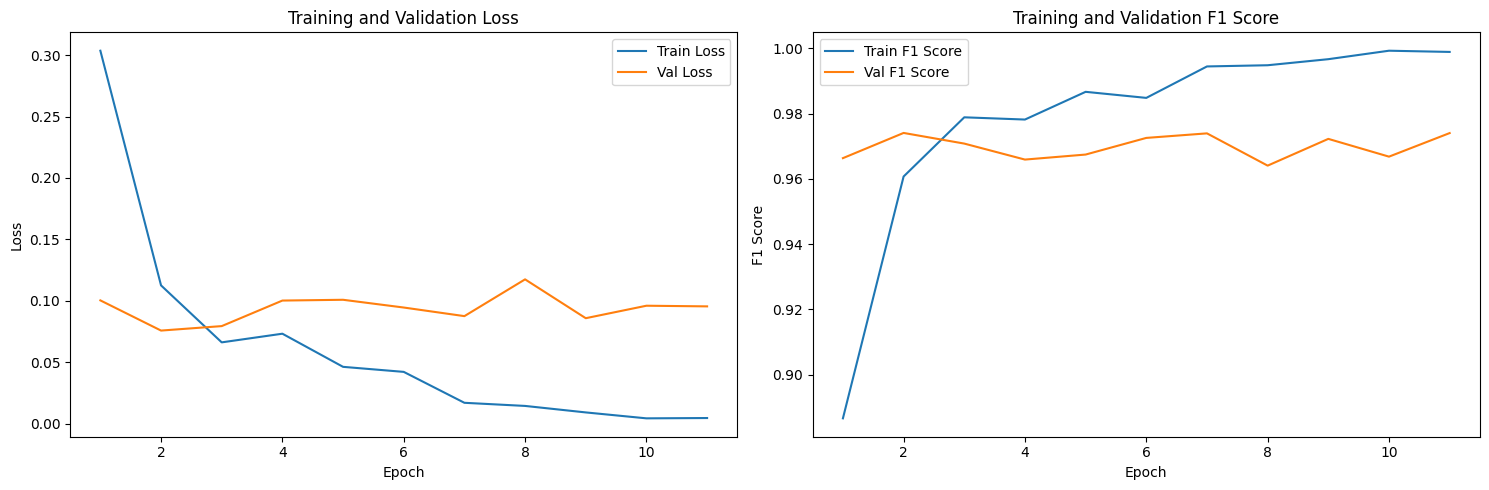

In [ ]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Test loading the model and evaluating it on validation set - took ??
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

# Start the timer
start_time = time.time()
start_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("Start time (Pacific Time):", start_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)  # Assuming you are loading the same architecture
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v3_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v3_best/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v3_base + 'vit_v3_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Save val_predictions and val_targets to a .npy file
np.save(output_path_vit_v3_base + 'vit_v3_val_predictions.npy', np.array(val_predictions))

# End the timer
end_time = time.time()
end_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("End time (Pacific Time):", end_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")

Start time (Pacific Time): 2024-05-10 03:32:22 AM PDT


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Loss: 0.0901, Validation F1 Score: 0.9703
End time (Pacific Time): 2024-05-10 03:33:44 AM PDT
Elapsed time: 0 hours, 1 minutes, 22 seconds


## Final ViT Model Results
I'm choosing ViT Model 1 to be the best ViT model because it had the smoothest train/val loss/f1 score curves, indicating better training stability. Let's retrive and visualize the results for this model.

In [4]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

### Load the data

In [2]:
# Load the numpy files - size 224x224 for ViT
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')
# test_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy')
# test_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Load model training dataframe and plot train/val loss/f1 score curves

In [8]:
output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'
# Load the model results from saved csv
epoch_df = pd.read_csv(output_path_vit_v1_base+'epoch_results.csv')
epoch_df.drop(columns=['Unnamed: 0'], inplace=True)
epoch_df

,Epoch,Train Loss,Train F1 Score,Val Loss,Val F1 Score
0,1,0.675521,0.749173,0.256384,0.842288
1,2,0.158968,0.929525,0.094125,0.966755
2,3,0.083050,0.975883,0.089735,0.969266
3,4,0.046718,0.988118,0.080304,0.974008
4,5,0.026301,0.991846,0.116483,0.977399
5,6,0.011619,0.996297,0.107251,0.967556
6,7,0.010172,0.996666,0.121700,0.970857
7,8,0.007090,0.996662,0.099014,0.968865


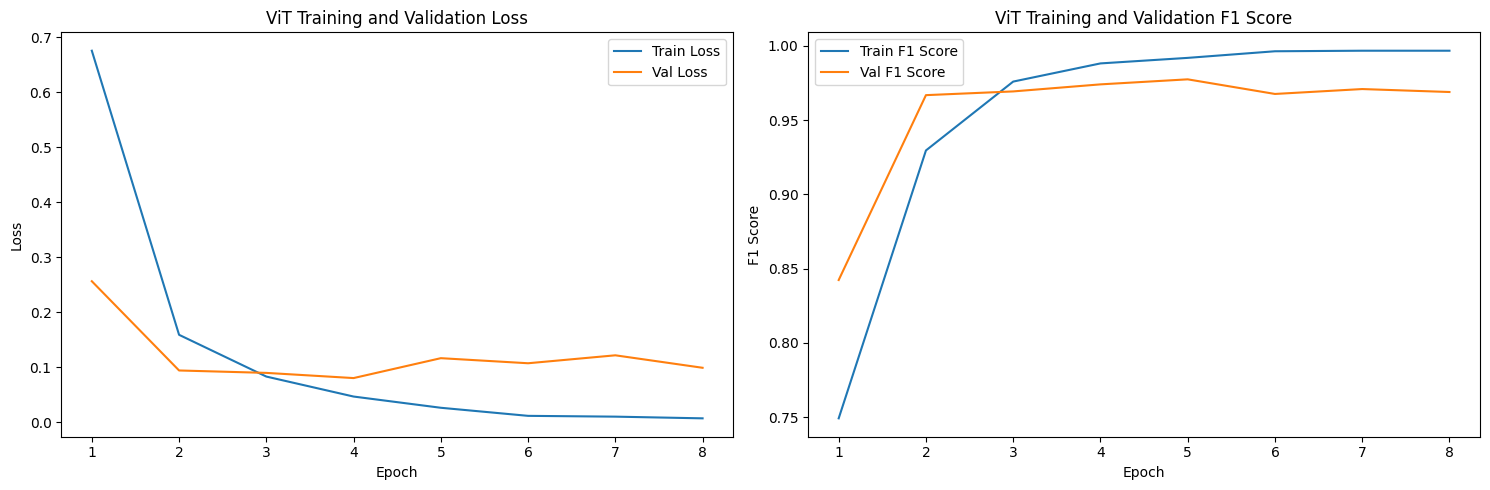

In [9]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('ViT Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('ViT Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


### Load the model

In [12]:
# Test loading the model and evaluating it on validation set - took ??
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

# Calculate class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
total_samples = len(train_labels)
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)  # Assuming you are loading the same architecture
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v1_base + 'vit_v1_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

### Evaluate the model on train

In [14]:
# Evaluate the model on the train set
loaded_model.eval()
train_predictions = []
train_targets = []
train_loss = 0.0
with torch.no_grad():
    for data, labels in train_loader:
        outputs = loaded_model(data)
        loss = criterion(outputs, labels.long())
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())

# Calculate train loss and F1 score
train_loss /= len(train_loader)
train_f1 = f1_score(train_targets, train_predictions, average='weighted')

print(f'Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}')

Train Loss: 0.0073, Train F1 Score: 0.9989


### Evaluate the model on val

In [30]:
# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = loaded_model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

Validation Loss: 0.0990, Validation F1 Score: 0.9689


### Print model classification report

In [16]:
from sklearn.metrics import classification_report

print(classification_report(val_targets, val_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        77
           1       0.99      1.00      0.99       179
           2       0.95      0.94      0.95       147
           3       1.00      0.99      1.00       175

    accuracy                           0.97       578
   macro avg       0.96      0.96      0.96       578
weighted avg       0.97      0.97      0.97       578



### Plot model confusion matrix

Define plotting function:

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Plot non-normalized confusion matrix:

Confusion matrix, without normalization


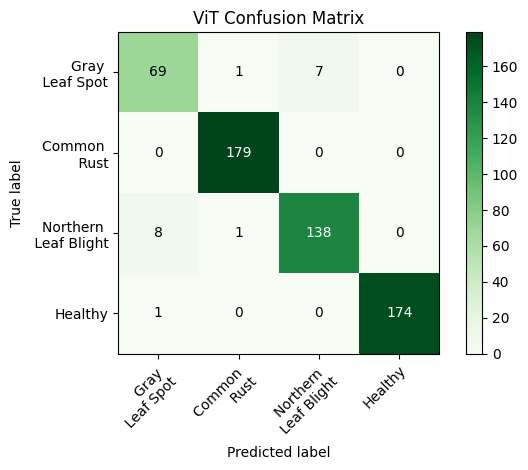

In [26]:
plot_confusion_matrix(val_targets, val_predictions, classes=class_names, title='ViT Confusion Matrix')
plt.show()

Plot normalized confusion matrix:

Normalized confusion matrix


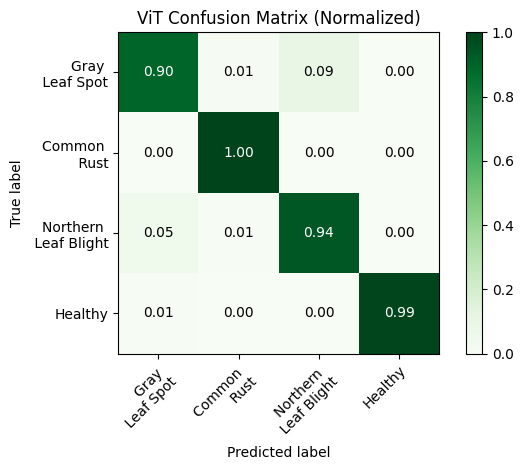

In [27]:
plot_confusion_matrix(val_targets, val_predictions, classes=class_names, normalize=True, title='ViT Confusion Matrix (Normalized)')
plt.show()

### Display Misclassified Leaf Images



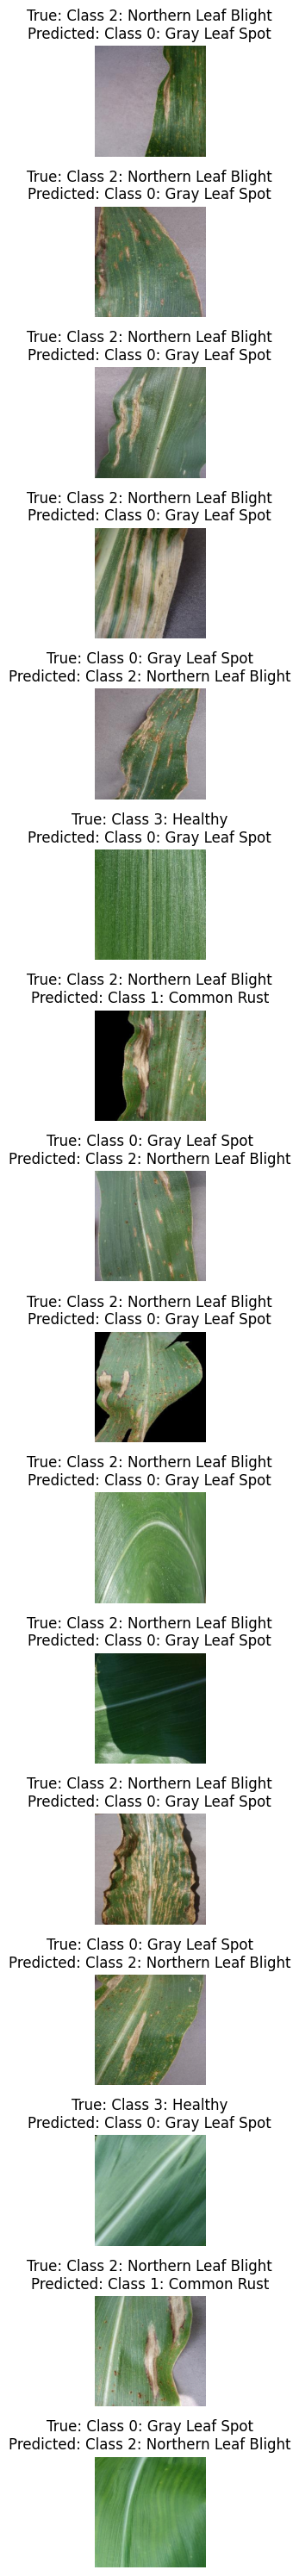

In [42]:
class_names = {0: 'Class 0: Gray Leaf Spot',
               1: 'Class 1: Common Rust',
               2: 'Class 2: Northern Leaf Blight',
               3: 'Class 3: Healthy'}

import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, titles, figsize=(15, 30)):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 1, figsize=figsize)
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Define a function to plot misclassified images
def plot_misclassified_samples(val_predictions, val_targets, val_loader, class_names):
    misclassified_indices = np.where(np.array(val_predictions) != np.array(val_targets))[0]
    # num_misclassified = min(5, len(misclassified_indices)) # can also sample if # of misclassified is high
    # sample_indices = np.random.choice(misclassified_indices, num_misclassified, replace=False)
    sample_indices = misclassified_indices

    misclassified_images = []
    true_labels = []
    predicted_labels = []

    for batch_images, batch_labels in val_loader:
        for idx, label in enumerate(batch_labels):
            if idx in sample_indices:
                image = batch_images[idx].permute(1, 2, 0).numpy()  # Convert from tensor to numpy array
                misclassified_images.append(image)
                true_label = class_names[val_targets[idx]]
                predicted_label = class_names[val_predictions[idx]]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

    plot_images(misclassified_images, [f'True: {true}\nPredicted: {pred}' for true, pred in zip(true_labels, predicted_labels)])

plot_misclassified_samples(val_predictions, val_targets, val_loader, class_names)



### Visualize Saliency Map
**Notes**
Code taken from Professor Hajij's shared notebook from [Day 3 in the readme](https://github.com/USFCA-MSDS/MSDS-631#syllabus):

https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb

**What's the point of saliency maps?**

A saliency map, in the context of a vision transformer model, highlights the regions of an input image that contribute the most to the model's prediction. It provides a visual representation of the importance or relevance of different parts of the image in making the classification decision.

The process of generating a saliency map typically involves computing the gradients of the model's output with respect to the input image pixels. These gradients indicate how small changes in each pixel would affect the model's prediction. By analyzing these gradients, the saliency map identifies the regions where changes would have the greatest impact on the model's output.

Saliency maps are useful for interpreting and understanding the decisions made by deep learning models, as they can reveal which parts of the input data are driving the model's predictions. They can also help identify potential areas for improvement or refinement in the model's performance.

In [44]:
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.43613595, 0.4974372, 0.3781651],
                         std=[0.21189487, 0.22010513, 0.21154968]),  # Normalize using train mean and std from EDA
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.43613595/0.21189487, -0.4974372/0.22010513, -0.3781651/0.21154968],
    std=[1/0.21189487, 1/0.22010513, 1/0.21154968]
)

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [45]:
from PIL import Image

<ipython-input-46-b1e3e2d02823>:3: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  resized_image1 = img1.resize((224, 224), Image.LINEAR)


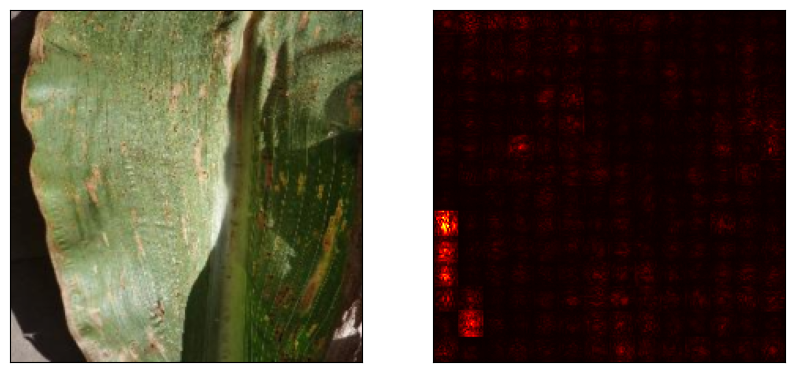

In [46]:
img1 = Image.open("/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357.JPG").convert('RGB')
img2 = Image.open("/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG").convert('RGB')
resized_image1 = img1.resize((224, 224), Image.LINEAR)
saliency(resized_image1, model)

<ipython-input-48-7fe162638cf0>:1: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  resized_image2 = img2.resize((224, 224), Image.LINEAR)


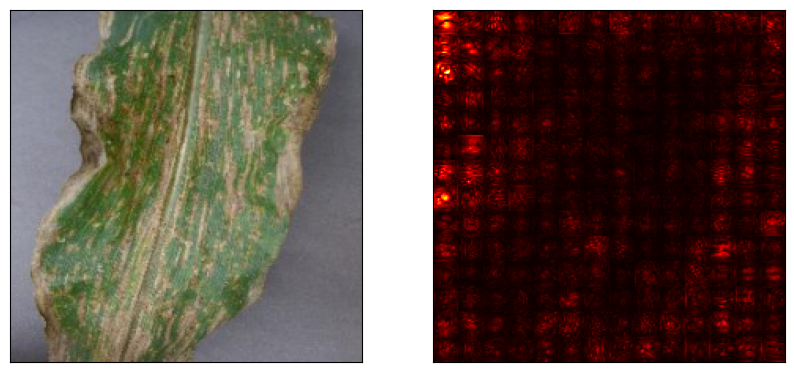

In [48]:
resized_image2 = img2.resize((224, 224), Image.LINEAR)
saliency(resized_image2, model)

In [49]:
!pip install jupyter_contrib_nbextensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 39.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.5 MB/s eta 0:00:00
  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428780 sha256=6364ed5e42e5a2af33dd611d2184c76cbce8a2d6b5d54c0b1eb85a7851d857c9
  Stored in directory: /root/.cache/pip/wheels/ea/cc/7d/99ef154f984726b1201c0f72cfe9c9d7c5132c1a2ae4d8677f
  Created wheel for jupyter_contrib_core: filename=jupyter_contrib_core-0.4.2-py2.py3-none-any.whl size=17482 sha256=770a367ea93b9b96b4e9f4ea0656a44b9071e3e55344160f4cbce559d15a8f39
  Stored in directory: /root/.cache/pip/wheels/a9/52/88/e0643cdfd68f0562087918c37dd583378648dbc3df68b907f7
Successfully built jupyter_contrib_nbextensions jupyter_contrib_core
